In [31]:
import zipfile
import os

# Replace 'your_file.zip' with the name of your uploaded zip file
zip_file_name = "/content/e2cnn-master.zip"

# Specify the directory where you want to extract the contents
extract_dir = "/content/"

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Contents extracted to {extract_dir}")


Contents extracted to /content/


In [32]:
import os


# Changer le répertoire actuel
os.chdir('/content/e2cnn-master')

# Vérifier le répertoire actuel
print("Répertoire actuel :", os.getcwd())


Répertoire actuel : /content/e2cnn-master


# General E(2)-Equivariant Steerable CNNs  -  A concrete example


In [33]:
import torch

from e2cnn import gspaces
from e2cnn import nn

Finally, we build a **Steerable CNN** and try it MNIST.

Let's also use a group a bit larger: we now build a model equivariant to $8$ rotations.
We indicate the group of $N$ discrete rotations as $C_N$, i.e. the **cyclic group** of order $N$.
In this case, we will use $C_8$.

Because the inputs are still gray-scale images, the input type of the model is again a *scalar field*.

However, internally we use *regular fields*: this is equivalent to a *group-equivariant convolutional neural network*.

Finally, we build *invariant* features for the final classification task by pooling over the group using *Group Pooling*.

The final classification is performed by a two fully connected layers.

# The model

Here is the definition of our model:

In [34]:
import torch
import torch.nn as nn

class NormalCNN(nn.Module):
    def __init__(self, n_classes=10):
        super(NormalCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 24, kernel_size=7, padding=1, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(24, 48, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(48, 48, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(48, 96, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(96, 96, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(96, 64, kernel_size=5, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=1, stride=1)
        )

        # Dynamically calculate flattened size
        dummy_input = torch.zeros(1, 1, 28, 28)  # Adjust input size if needed
        dummy_output = self.conv6(self.conv5(self.conv4(self.conv3(self.conv2(self.conv1(dummy_input))))))
        flattened_size = dummy_output.numel()

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 64),
            nn.BatchNorm1d(64),
            nn.ELU(inplace=True),
            nn.Linear(64, n_classes),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.fc(x)
        return x


Let's try the model on *rotated* MNIST

In [35]:
# Step 1: Import necessary modules
import torch
from rotated_mnist import flattened_rotMNIST

# Step 2: Set parameters for the new dataset
num_tasks = 8  # Number of rotation tasks
per_task_rotation = 45  # Degrees of rotation per task
batch_size = 64  # Batch size for training/testing

# Step 3: Load the rotated MNIST dataset
train_loader, test_loader = flattened_rotMNIST(
    num_tasks=num_tasks,
    per_task_rotation=per_task_rotation,
    batch_size=batch_size
)

for images, labels, angles in train_loader:
    print(f"Input image shape after transform: {images.shape}")  # Should be [batch_size, 1, 29, 29]
    break


Input image shape after transform: torch.Size([64, 1, 29, 29])


In [36]:
from torch.utils.data import Dataset
from torchvision.transforms import RandomRotation
from torchvision.transforms import Pad
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose

import numpy as np

from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'


Build the dataset

In [37]:
class MnistRotDataset(Dataset):

    def __init__(self, mode, transform=None):
        assert mode in ['train', 'test']

        if mode == "train":
            file = "mnist_rotation_new/mnist_all_rotation_normalized_float_train_valid.amat"
        else:
            file = "mnist_rotation_new/mnist_all_rotation_normalized_float_test.amat"

        self.transform = transform

        data = np.loadtxt(file, delimiter=' ')

        self.images = data[:, :-1].reshape(-1, 28, 28).astype(np.float32)
        self.labels = data[:, -1].astype(np.int64)
        self.num_samples = len(self.labels)

    def __getitem__(self, index):
        image, label = self.images[index], self.labels[index]
        image = Image.fromarray(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.labels)

# images are padded to have shape 29x29.
# this allows to use odd-size filters with stride 2 when downsampling a feature map in the model
pad = Pad((0, 0, 1, 1), fill=0)

# to reduce interpolation artifacts (e.g. when testing the model on rotated images),
# we upsample an image by a factor of 3, rotate it and finally downsample it again
resize1 = Resize(87)
resize2 = Resize(29)

totensor = ToTensor()

Let's build the model

In [38]:
model = NormalCNN().to(device)

The model is now randomly initialized.
Therefore, we do not expect it to produce the right class probabilities.

However, the model should still produce the same output for rotated versions of the same image.
This is true for rotations by multiples of $\frac{\pi}{2}$, but is only approximate for rotations by $\frac{\pi}{4}$.

Let's test it on a random test image:
we feed eight rotated versions of the first image in the test set and print the output logits of the model for each of them.

In [39]:

def test_model(model: torch.nn.Module, x: Image):
    # evaluate the `model` on 8 rotated versions of the input image `x`
    model.eval()

    wrmup = model(torch.randn(1, 1, 29, 29).to(device))
    del wrmup

    x = resize1(pad(x))

    print()
    print('##########################################################################################')
    header = 'angle |  ' + '  '.join(["{:6d}".format(d) for d in range(10)])
    print(header)
    with torch.no_grad():
        for r in range(8):
            x_transformed = totensor(resize2(x.rotate(r*45., Image.BILINEAR))).reshape(1, 1, 29, 29)
            x_transformed = x_transformed.to(device)

            y = model(x_transformed)
            y = y.to('cpu').numpy().squeeze()

            angle = r * 45
            print("{:5d} : {}".format(angle, y))
    print('##########################################################################################')
    print()



The output of the model is already almost invariant.
However, we still observe small fluctuations in the outputs.

This is because the model contains some operations which might break equivariance.
For instance, every convolution includes a padding of $2$ pixels per side. This is adds information about the actual orientation of the grid where the image/feature map is sampled because the padding is not rotated with the image.

During training, the model will observe rotated patterns and will learn to ignore the noise coming from the padding.

So, let's train the model now.
The model is exactly the same used to train a normal *PyTorch* architecture:

In [40]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

In [41]:
import csv

# Création ou ouverture d'un fichier CSV
csv_file = "accuracy_log.csv"
with open(csv_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Test Accuracy"])  # En-tête du fichier

# Entraînement du modèle
for epoch in range(11):
    model.train()
    for i, (x, t, _) in enumerate(train_loader):

        optimizer.zero_grad()

        x = x.to(device)
        t = t.to(device)

        y = model(x)

        loss = loss_function(y, t)

        loss.backward()

        optimizer.step()

    total = 0
    correct = 0
    with torch.no_grad():
        model.eval()
        for i, (x, t, _) in enumerate(test_loader):
            x = x.to(device)
            t = t.to(device)

            y = model(x)

            _, prediction = torch.max(y.data, 1)
            total += t.shape[0]
            correct += (prediction == t).sum().item()

    # Calcul de l'accuracy
    test_accuracy = correct / total * 100.0
    print(f"Epoch {epoch} | Test Accuracy: {test_accuracy:.2f}%")

    # Ajout des résultats au fichier CSV
    with open(csv_file, mode="a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([epoch, test_accuracy])

Epoch 0 | Test Accuracy: 92.24%
Epoch 1 | Test Accuracy: 94.38%
Epoch 2 | Test Accuracy: 95.02%
Epoch 3 | Test Accuracy: 95.59%
Epoch 4 | Test Accuracy: 96.05%
Epoch 5 | Test Accuracy: 95.76%
Epoch 6 | Test Accuracy: 95.90%
Epoch 7 | Test Accuracy: 96.16%
Epoch 8 | Test Accuracy: 96.27%
Epoch 9 | Test Accuracy: 96.39%
Epoch 10 | Test Accuracy: 96.38%


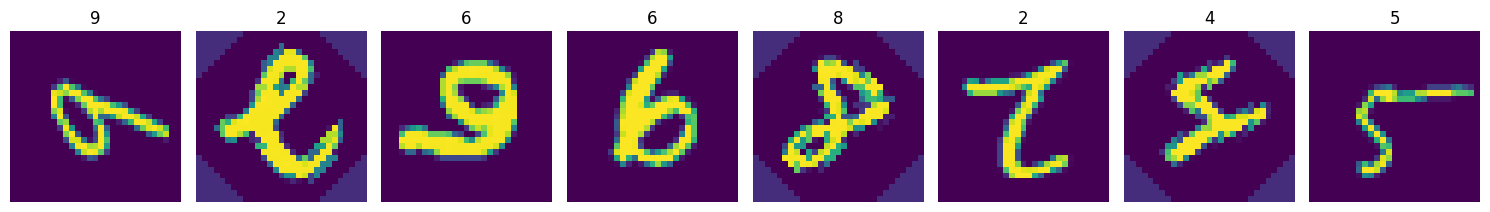

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display a batch of images
def show_images_from_loader(loader, classes, num_images=8):
    """
    Displays a batch of images from the given DataLoader.

    Args:
    - loader: The DataLoader to pull images from (e.g., test_loader).
    - classes: A list of class names corresponding to the dataset labels.
    - num_images: The number of images to display (default is 8).
    """
    # Get a single batch from the loader
    data_iter = iter(loader)
    images, labels, _ = next(data_iter)

    # Limit to the specified number of images
    images = images[:num_images]
    labels = labels[:num_images]

    # Convert from torch tensors to numpy for visualization
    images = images.numpy()

    # Create a figure
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        ax = axes[i]
        img = np.transpose(images[i], (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(classes[labels[i]])

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming you have a DataLoader named `test_loader` and a `classes` list
# For example: classes = ['cat', 'dog', 'bird', ...] based on your dataset
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']  # Replace with your actual class names
show_images_from_loader(test_loader, classes)
